# Sensitivity study: K-means
How do the settings used when running K-means affect the classification performance?

We will vary 2 parameters:
  * Number of initializations
  * Number of cluster centers


## Module imports and loading data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from pathlib import Path
import pickle
import seaborn as sns

from scipy.stats import pearsonr

import skimage
from skimage.exposure import histogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples

import sys
sys.path.insert(0,'../')
from helper import (classification_tools as ct,
                   visualize as vis)
%matplotlib inline

In [2]:
fc1_path = Path('..','data','features','VGG16_fc1_features_std.pickle')
assert fc1_path.is_file()

le_path = Path('..','models','label_encoder.pickle')
assert le_path.is_file()


with open(fc1_path, 'rb') as f:
    data = pickle.load(f)

with open(le_path, 'rb') as f:
    le = pickle.load(f)


In [3]:
files = data['filename']
fc1 = data['features']
labels = data['labels']
y_gt = le.transform(labels)

# PCA and t-SNE visualization
verify that everything is loaded correctly before proceeding.

In [4]:
pca = PCA(n_components=50, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False)
x = pca.fit_transform(fc1)
x_nw = pca_nw.fit_transform(fc1)

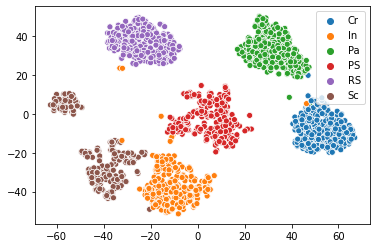

In [5]:
tsne = TSNE(n_components=2, random_state=12214)
x_nw_tsne = tsne.fit_transform(x_nw)
fig, ax = plt.subplots()
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], hue=labels, hue_order=le.labels_ordered)

# Influence of number of initializations on cluster performance
We will run k-means 5000 times, each with a single initialization step, and track the accuracy and inertia of each trial. The process will be repeated for clustering both whitened and unwhitened PCA components, which will reveal an important trend.

In [6]:
n_tests=5000
rs = np.random.RandomState(seed=3688757485)
rs_w = rs.randint(2**32, size=n_tests)
rs_nw = rs.randint(2**32, size=n_tests)

use_cache=True
kmeans_acc_vs_inertia_cache_path = Path('..','.neu_cache','kmeans_acc_vs_inertia.pickle')

if not use_cache or not kmeans_acc_vs_inertia_cache_path.is_file():
    accs_w = np.zeros(n_tests)
    inertias_w = np.zeros(n_tests)
    
    accs_nw = np.zeros(n_tests)
    inertias_nw = np.zeros(n_tests)
    for i, (seed_w, seed_nw) in enumerate(zip(rs_w, rs_nw)):
        
        # cluster results for each random seed, storing the  accuracy and inertia
        kmeans = KMeans(n_clusters=7, init='k-means++', n_init=1, random_state=seed_w)
        kmeans.fit(x)
        y_pred = ct.label_matcher(kmeans.labels_, y_gt)
        CM = confusion_matrix(y_gt, y_pred)
        accs_w[i] = CM.trace()/CM.sum()
        inertias_w[i] = kmeans.inertia_
        
        # repeat for unwhitened components
        kmeans_nw = KMeans(n_clusters=7, init='k-means++', n_init=1, random_state=seed_nw)
        kmeans_nw.fit(x_nw)
        y_pred_nw = ct.label_matcher(kmeans_nw.labels_, y_gt)
        CM_nw = confusion_matrix(y_gt, y_pred_nw)
        accs_nw[i] = CM_nw.trace()/CM_nw.sum()
        inertias_nw[i] = kmeans_nw.inertia_
    with open(kmeans_acc_vs_inertia_cache_path, 'wb') as f:
        pickle.dump({'accs_w': accs_w,
                     'accs_nw': accs_nw,
                     'inertias_w': inertias_w,
                     'inertias_nw': inertias_nw},
                    f)
else:
    with open(kmeans_acc_vs_inertia_cache_path, 'rb') as f:
        results_ = pickle.load(f)
        accs_nw = results_['accs_nw']
        accs_w = results_['accs_w']
        inertias_nw = results_['inertias_nw']
        inertias_w = results_['inertias_w']


### Visualizing Results

In [7]:
def format_hist(data, bins):
    """
    Computes histogram with specified number of bins.
    
    Parameters
    ----------
    data: ndarray
        n-element array of data from which to compute histogram
    
    bins: int
        number of bins to use in histogram
    
    Returns
    ---------
    hist: ndarray
        *bins* element array of counts from the histogram
    
    bin_centers: ndarray
        *bins* element array where each item is the center of the bin in the histogram 
    
    """
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = np.asarray([np.mean([x,y]) for x,y in zip(bin_edges[:-1], bin_edges[1:])])
    
    return hist, bin_centers
    
hist_w, bins_w = format_hist(accs_w, bins=20)

hist_nw, bins_nw = format_hist(accs_nw, bins=20)


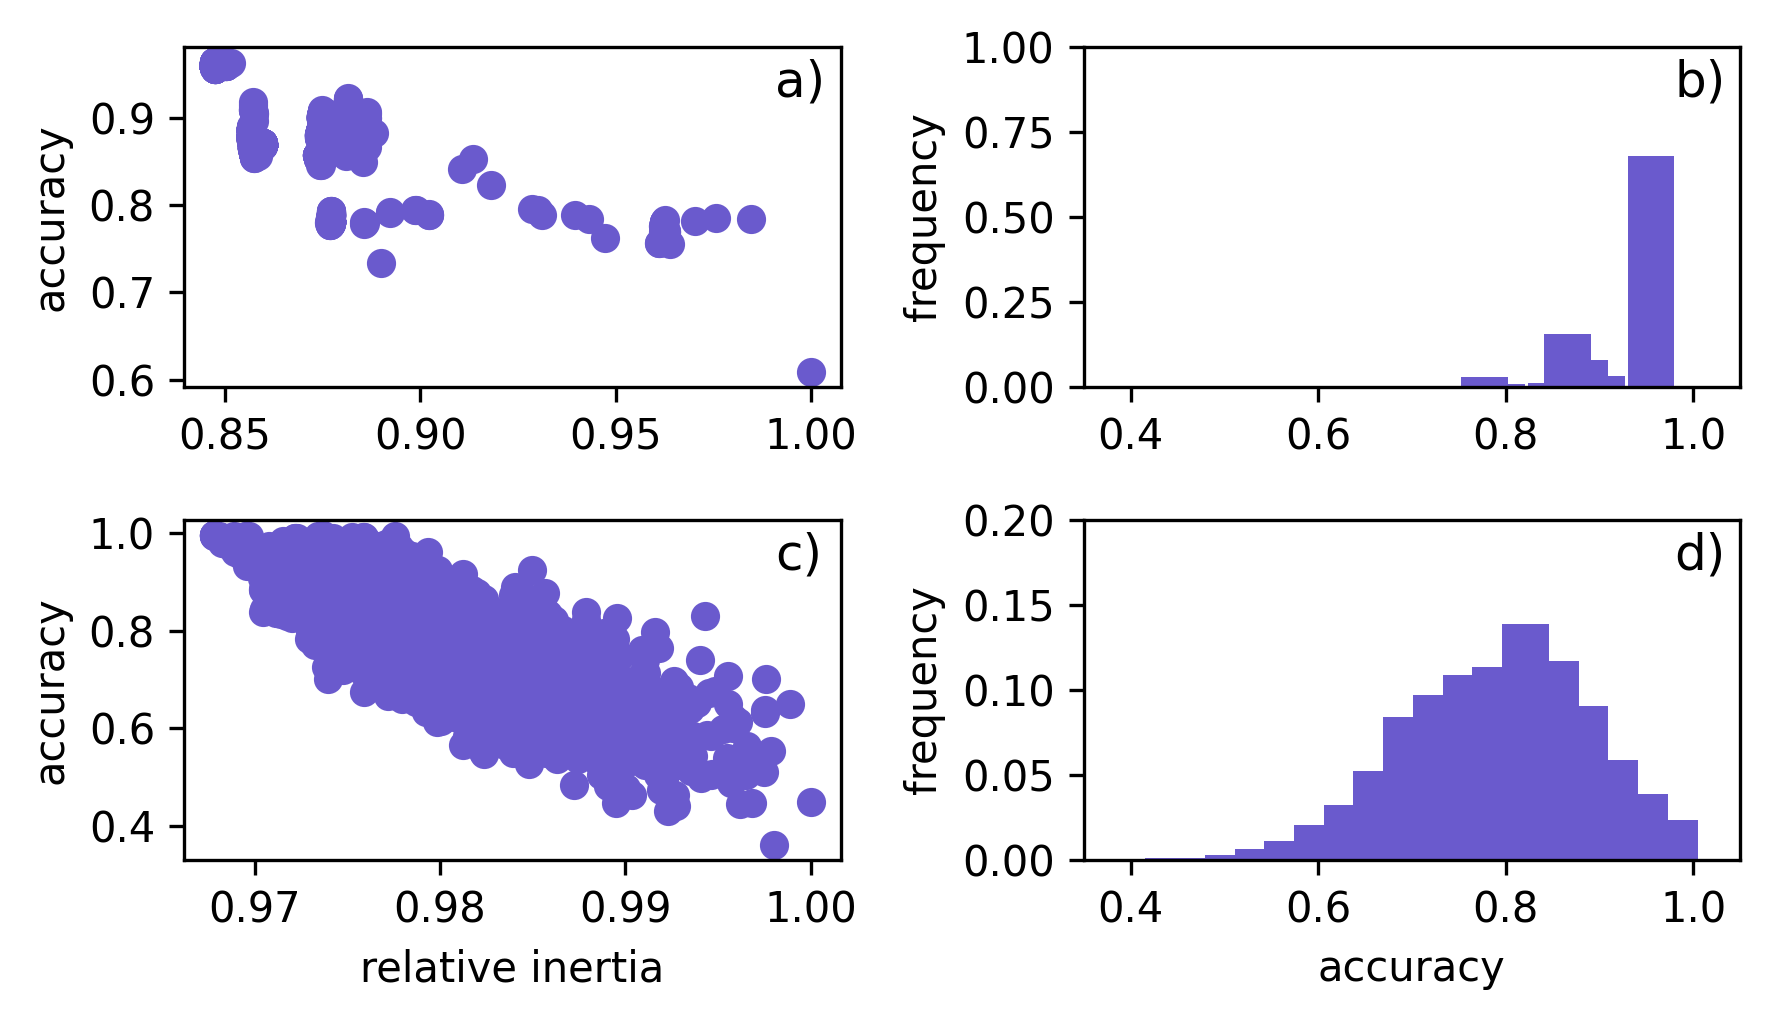

In [8]:
fig, axs = plt.subplots(2,2, figsize=(6,3.5), dpi=300,facecolor='w')

ax = axs[0,0]
ax.plot(inertias_nw/inertias_nw.max(), accs_nw, 'o', color='slateblue')

ax = axs[0,1]
ax.bar(bins_nw, hist_nw/hist_nw.sum(), width=0.05, color='slateblue')
ax.set_xlim([0.35, 1.05])

ax.set_yticks(np.linspace(0,1,5), minor=True)

ax = axs[1,0]
ax.plot(inertias_w/inertias_w.max(), accs_w, 'o', color='slateblue')
ax.set_xlabel('relative inertia')


ax = axs[1,1]
ax.bar(bins_w, hist_w/hist_w.sum(), width=0.05, color='slateblue')
ax.set_xlim([0.35, 1.05])
ax.set_yticks(np.linspace(0,0.2,5), minor=True)
ax.set_xlabel('accuracy')


for a in axs[:,1].ravel():
    a.set_ylabel('frequency')
for a in axs[:,0].ravel():
    a.set_ylabel('accuracy')

for a, title in zip(axs.ravel(), ['a','b','c','d']):
    a.set_title("{})".format(title), loc='left', **{'x':0.9,'y':0.78})

fig.tight_layout()
fig.savefig(Path('..','Figures','kmeans_n_iter.png'), bbox_inches='tight')

The trends are covered in detail in the paper, but the main points are as follows:
  * Without whitening, there are a relatively small number of final cluster positions. Most of the time, even with a single initialiation step, the model reaches 96\% accuarcy.
  * With whitening, there are a lot of local minima that the centroids can become trapped in. On average the model achives 80\% accuracy for a single run. However, 
    accuracy tends to increase as the inertia decreases. Thus, running many initializations and taking the result with the lowest inertia allows us to consistently reach 99+\% accuracy.

In [9]:
print('No Whitening')
print('\tmin acc: \t{:.3f}\n\tmax acc:\t{:.3f}\nacc-min inertia:\t{:.3f}\n'.format(
    accs_nw.min(), accs_nw.max(), accs_nw[inertias_nw.argmin()]))

print('With Whitening')
print('\tmin acc: \t{:.3f}\n\tmax acc:\t{:.3f}\nacc-min inertia:\t{:.3f}'.format(
    accs_w.min(), accs_w.max(), accs_w[inertias_w.argmin()]))

No Whitening
	min acc: 	0.609
	max acc:	0.964
acc-min inertia:	0.961

With Whitening
	min acc: 	0.362
	max acc:	0.996
acc-min inertia:	0.996


In [10]:
print('No whitening')
print('\ttop bin accuracy:\t{:.3f}\n\ttop bin fraction:\t{:.3f}\n\n'
      .format(bins_nw[-2], hist_nw[-1]/hist_nw.sum()))
bins_nw[-2]

print('With whitening')
print('\ttop bin accuracy:\t{:.3f}\n\ttop bin fraction:\t{:.3f}'
      .format(0.99, (accs_w > 0.99).sum()/len(accs_w)))


No whitening
	top bin accuracy:	0.937
	top bin fraction:	0.680


With whitening
	top bin accuracy:	0.990
	top bin fraction:	0.007


In [11]:
bins_w[hist_w.argmax():hist_w.argmax()+2]

array([0.82123611, 0.85293056])

In [12]:
print('Pearson r correlation between accuracy and inertia')
print('whitening: \t{:.3f}'.format(pearsonr(inertias_w, accs_w)[0]))
print('no whitening:\t{:.3f}'.format(pearsonr(inertias_nw, accs_nw)[0]))

Pearson r correlation between accuracy and inertia
whitening: 	-0.794
no whitening:	-0.762


# Influence of number of clusters on accuracy
We already saw that changing the number of clusters can drastically affect the performance during other steps of the sensitivity analysis.
What about for the original fc1 features?

In [13]:
use_cache = True
kmeans_k_cache_path = Path('..','.neu_cache','kmeans_acc_vs_k.pickle')

if not use_cache or not kmeans_k_cache_path.is_file():
    k_values = np.arange(6,26)
    acc_k = np.zeros(k_values.shape)
    rs = np.random.RandomState(seed=3689319368)
    
    
    for i, (k, state) in enumerate(zip(k_values, rs.randint(2**32,size=len(k_values)))):

        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=500, random_state=state)
        kmeans.fit(x)
        y_pred = ct.label_matcher(kmeans.labels_, y_gt)
        CM = confusion_matrix(y_gt, y_pred)
        acc_k[i] = CM.trace()/CM.sum()
    
    with open(kmeans_k_cache_path, 'wb') as f:
        pickle.dump({'k_values': k_values,
                    'acc_k': acc_k},
                    f)
else:
    with open(kmeans_k_cache_path, 'rb') as f:
        results_ = pickle.load(f)
        k_values = results_['k_values']
        acc_k = results_['acc_k']
    

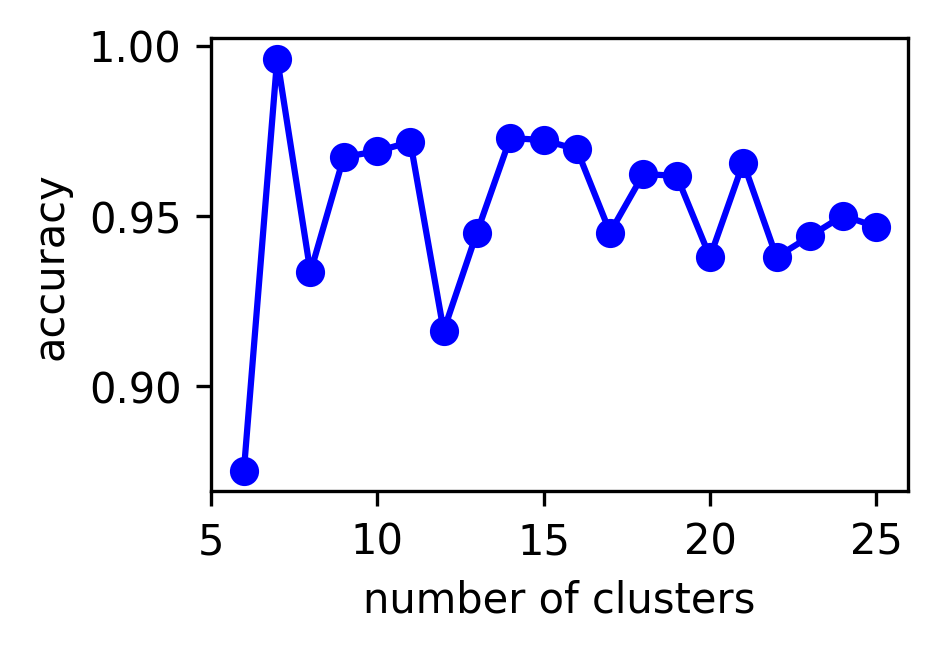

In [14]:
fig, ax = plt.subplots(dpi=300, figsize=(3,2))
ax.plot(k_values, acc_k, '-bo')
#ax[1].plot(K, [np.median(x) for x in silhouettes], ':o')
ax.set_xticks(range(5,26,5))
ax.set_xlabel('number of clusters')
ax.set_ylabel('accuracy')
plt.show()

Using 7 clusters results in significantly higher accuracy than any other number between 6 and 25. Interestingly, using 6 clusters, equal to the number of defects, results in the lowest accuracy. This highlights
the effect that splitting scratches into 2 clusters has.



In [15]:
rs2 = np.random.RandomState(seed=3689319368)
k_ = np.arange(6,25)
states = rs2.randint(2**32, size=k_.shape)

i = 8


kmeans = KMeans(n_clusters=k_[i], init='k-means++', n_init=500, random_state=states[i])
kmeans.fit(x)
y_pred = ct.label_matcher(kmeans.labels_, y_gt)
CM = confusion_matrix(y_gt, y_pred)
acc = CM.trace()/CM.sum()

In [16]:
cluster_mapper = {}
for p in np.unique(y_pred):
    y_clusters = kmeans.labels_[y_pred == p]
    for idx, value in enumerate(np.unique(y_clusters)):
        cluster_mapper[value] = '{}-{}'.format(le.inverse_transform([p])[0], idx)
    

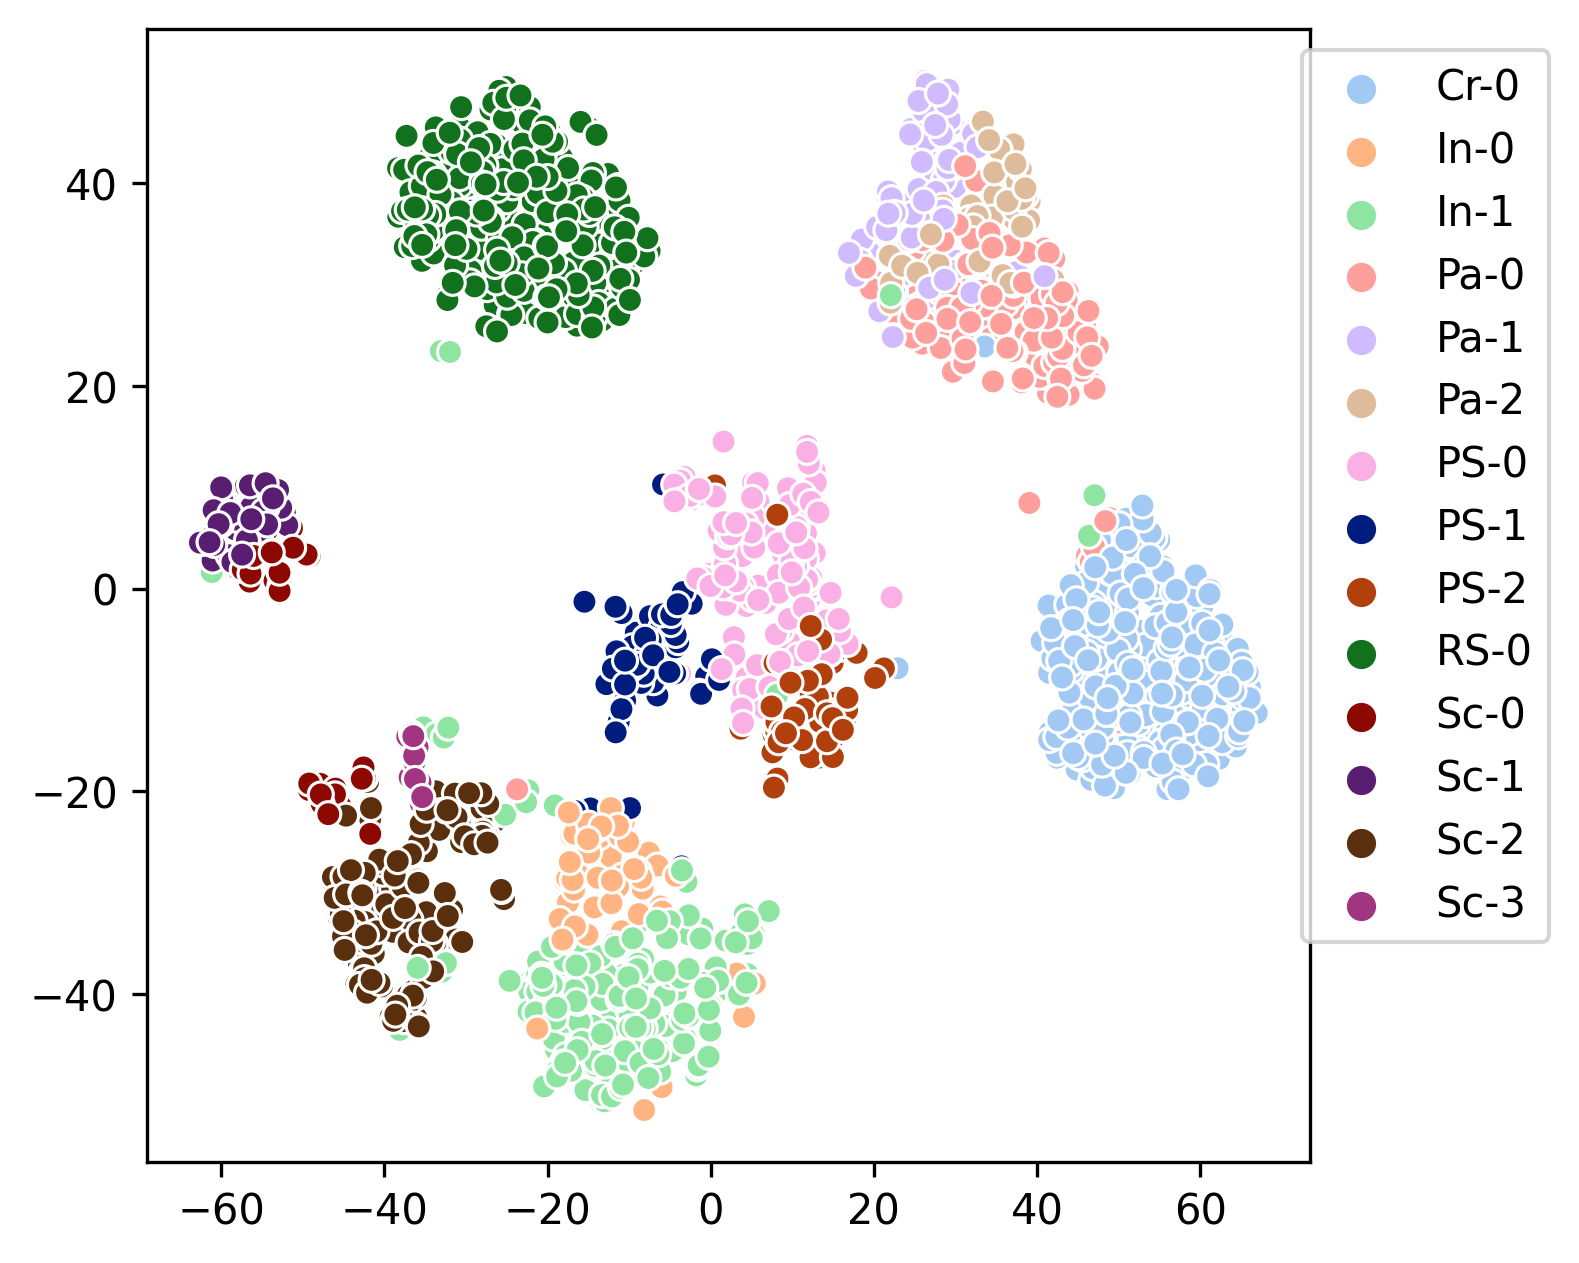

In [17]:
palette = np.concatenate((sns.color_palette('pastel', 7), sns.color_palette('dark', 7)), axis=0)
hue = [cluster_mapper[x] for x in kmeans.labels_]
hue_order=sorted(cluster_mapper.values(), key=lambda x: x.upper())


fig, ax = plt.subplots(dpi=300, figsize=(5,5))
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], hue=hue, hue_order=hue_order, palette=dict(zip(hue_order, palette)), ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(1.1,1))

When there are too many centroids, clusters get split up, leaving regions that are between the main clusters that get misclassified.